In [1]:
from pandas import Series
import pandas as pd
import numpy as np
import collections

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import recall_score, precision_score, f1_score, log_loss
from sklearn.metrics import accuracy_score

import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 8)

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

# для kaggle
#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
sample_submission = pd.read_csv('./sample_submission.csv')

# для kaggle
#train = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')
#test= pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')
#sample_submission = pd.read_csv('/kaggle/input/sf-dst-scoring/sample_submission.csv')

In [3]:
pd.set_option('display.max_columns', None)
print('Размерность тренировочного датасета: ', train.shape)
display(train.head(3))
print('Размерность тестового датасета: ', test.shape)
display(test.head(3))
print('Размерность sample_submission: ', sample_submission.shape)
display(sample_submission.head(3))

Размерность тренировочного датасета:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0


Размерность тестового датасета:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y


Размерность sample_submission:  (24354, 2)


,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370


In [4]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

In [5]:
train.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default'],
      dtype='object')

In [6]:
test.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport'],
      dtype='object')

Описания полей датасета

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

### Работа с пропусками

In [7]:
train.isnull().sum(), test.isnull().sum()

(client_id             0
 app_date              0
 education           307
 sex                   0
 age                   0
 car                   0
 car_type              0
 decline_app_cnt       0
 good_work             0
 score_bki             0
 bki_request_cnt       0
 region_rating         0
 home_address          0
 work_address          0
 income                0
 sna                   0
 first_time            0
 foreign_passport      0
 default               0
 dtype: int64,
 client_id             0
 app_date              0
 education           171
 sex                   0
 age                   0
 car                   0
 car_type              0
 decline_app_cnt       0
 good_work             0
 score_bki             0
 bki_request_cnt       0
 region_rating         0
 home_address          0
 work_address          0
 income                0
 sna                   0
 first_time            0
 foreign_passport      0
 dtype: int64)

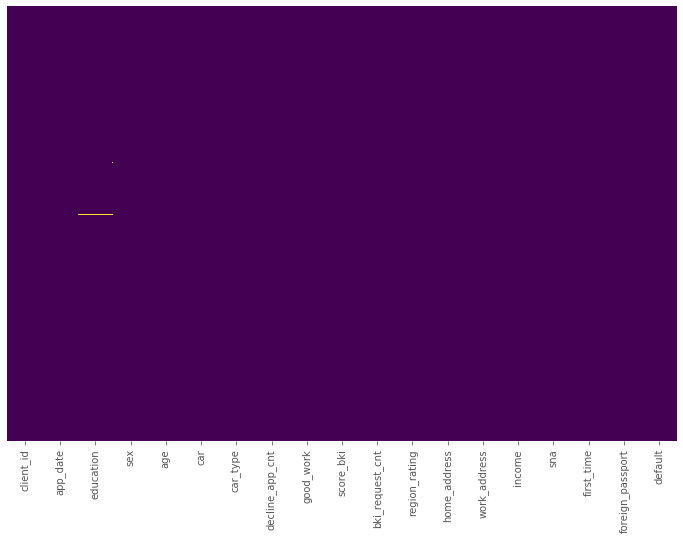

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
sns_heatmap = sns.heatmap(train.isnull(),
                          yticklabels=False,
                          cbar=False,
                          cmap='viridis')

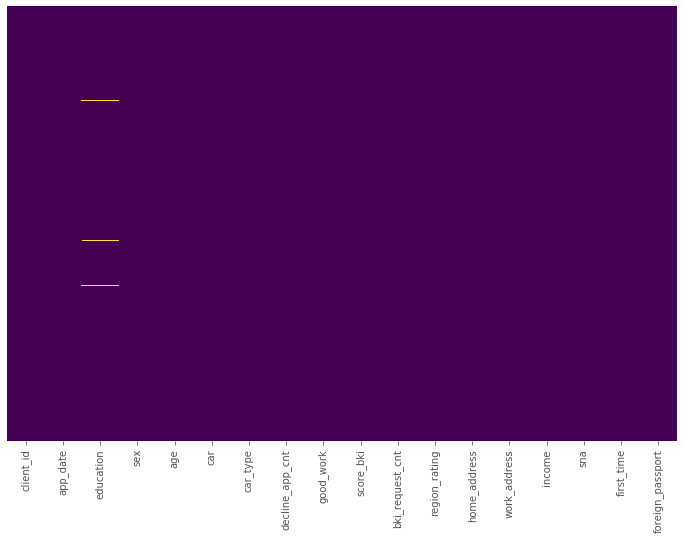

In [9]:
fig, ax = plt.subplots(figsize=(12,8))
sns_heatmap = sns.heatmap(test.isnull(), yticklabels=False, cbar=False, cmap='viridis')

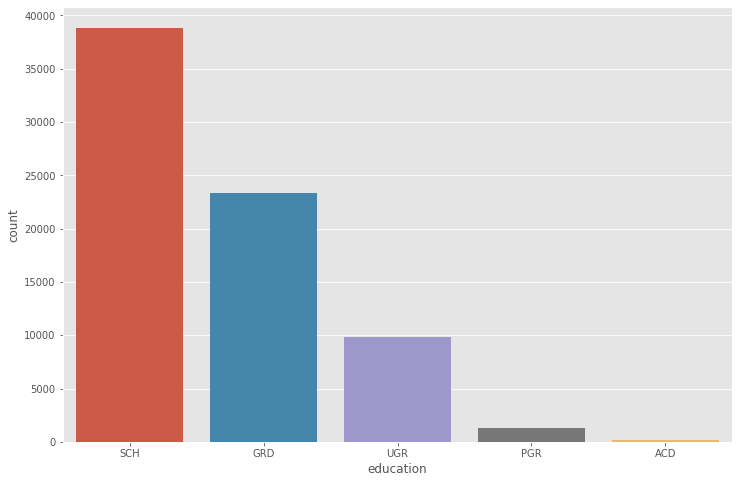

In [10]:
# посмотрим на распределение образования
sns.countplot(train['education'])
# видно, что большая часть заёмщиков имеет образование SCH

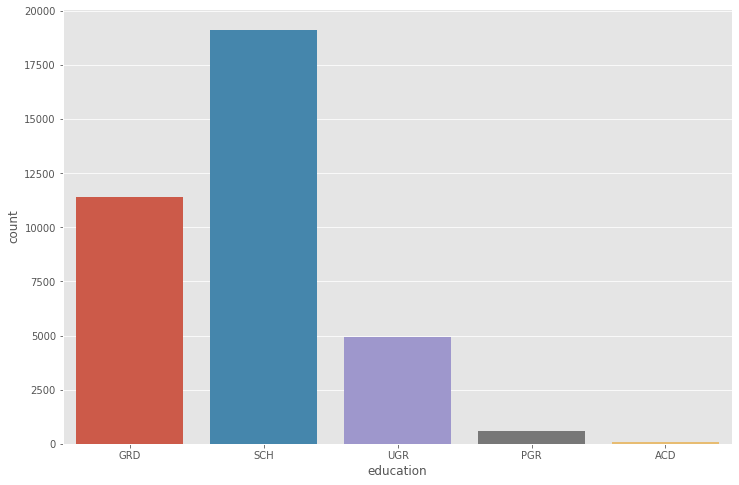

In [11]:
sns.countplot(test['education'])
# видно, что большая часть заёмщиков имеет образование SCH

In [12]:
# заполним пропуски наиболее частыми значениями

c_1 = collections.Counter(train['education'])
c_2 = collections.Counter(test['education'])

train['education'].fillna(c_1.most_common()[0][0], inplace=True)
test['education'].fillna(c_2.most_common()[0][0], inplace=True)

In [13]:
# проверим заполнение
train.isnull().sum(), test.isnull().sum()

(client_id           0
 app_date            0
 education           0
 sex                 0
 age                 0
 car                 0
 car_type            0
 decline_app_cnt     0
 good_work           0
 score_bki           0
 bki_request_cnt     0
 region_rating       0
 home_address        0
 work_address        0
 income              0
 sna                 0
 first_time          0
 foreign_passport    0
 default             0
 dtype: int64,
 client_id           0
 app_date            0
 education           0
 sex                 0
 age                 0
 car                 0
 car_type            0
 decline_app_cnt     0
 good_work           0
 score_bki           0
 bki_request_cnt     0
 region_rating       0
 home_address        0
 work_address        0
 income              0
 sna                 0
 first_time          0
 foreign_passport    0
 dtype: int64)

In [14]:
# Взглянем поближе на признак app_date
train.app_date.head(5), test.app_date.head(5)

(0    01FEB2014
 1    12MAR2014
 2    01FEB2014
 3    23JAN2014
 4    18APR2014
 Name: app_date, dtype: object,
 0    22MAR2014
 1    24JAN2014
 2    23MAR2014
 3    03FEB2014
 4    04FEB2014
 Name: app_date, dtype: object)

In [15]:
# Сконветируем в более удобный формат даты
train.app_date = pd.to_datetime(train.app_date)
test.app_date = pd.to_datetime(test.app_date)
print(train.app_date.head(5))
print(test.app_date.head(5))

0   2014-02-01
1   2014-03-12
2   2014-02-01
3   2014-01-23
4   2014-04-18
Name: app_date, dtype: datetime64[ns]
0   2014-03-22
1   2014-01-24
2   2014-03-23
3   2014-02-03
4   2014-02-04
Name: app_date, dtype: datetime64[ns]


In [16]:
#На основе признака app_date делаем новый признак
current_date = pd.to_datetime('24DEC2020')
# Количество дней, прошедших со дня подачи заявки
train['days'] = (current_date - train.app_date).dt.days
test['days'] = (current_date - test.app_date).dt.days

In [17]:
train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,days
0,25905,2014-02-01,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,2518
1,63161,2014-03-12,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,2479
2,25887,2014-02-01,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,2518
3,16222,2014-01-23,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,2527
4,101655,2014-04-18,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,2442


### Разделим колонки по типам данным для большего удобства работы и изучения

In [18]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'home_address', 'work_address',
            'sna', 'first_time', 'region_rating']
num_cols = ['days', 'age', 'decline_app_cnt', 'score_bki',
            'bki_request_cnt', 'income']

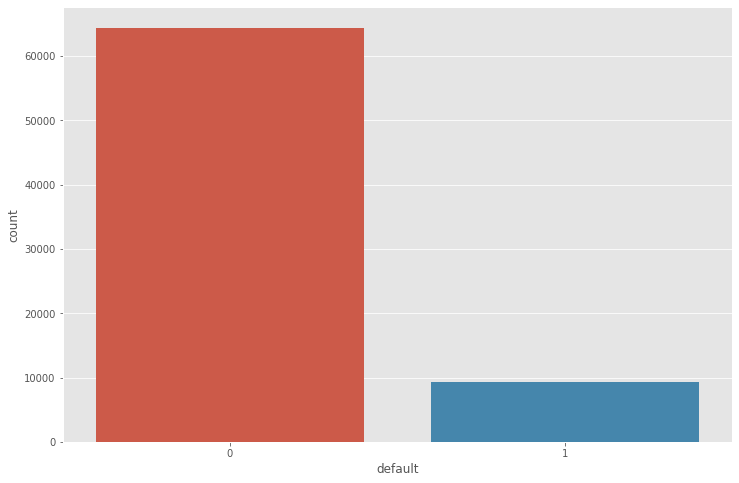

In [19]:
sns.countplot(train['default'])

In [20]:
train['default'].value_counts()
# Очевидно что выборка распределена неравномерно и недефолтных клиентов заметно больше

0    64427
1     9372
Name: default, dtype: int64

In [21]:
# попробуем oversampling для устранения дисбаланса

train_0 = train.query('default == 0')
train_1 = train.query('default == 1')
koeff = int(len(train_0)/len(train_1))
for i in range(koeff):
    train = train.append(train_1).reset_index(drop=True) # объединяем

In [22]:
train['default'].value_counts()

1    65604
0    64427
Name: default, dtype: int64

Построим графики распределения численных переменных

In [23]:
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return lower_bound, upper_bound

In [24]:
# убираем выбросы в численных столбцах
num_cols_1 = ['age', 'income','bki_request_cnt','score_bki']
for colname in num_cols_1:
    d = outliers_iqr(train[colname])
    train = train.loc[train[colname].between(d[0], d[1])]

In [25]:
train['bki_age_reg'] = (train['score_bki']/train['age'])*train['region_rating']
test['bki_age_reg'] = (test['score_bki']/test['age'])*test['region_rating']
num_cols.append('bki_age_reg')

train['new_one'] = (train['score_bki']/train['age'])**train['sna']
test['new_one'] = (test['score_bki']/test['age'])**test['sna']
num_cols.append('new_one')

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116236 entries, 0 to 130030
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         116236 non-null  int64         
 1   app_date          116236 non-null  datetime64[ns]
 2   education         116236 non-null  object        
 3   sex               116236 non-null  object        
 4   age               116236 non-null  int64         
 5   car               116236 non-null  object        
 6   car_type          116236 non-null  object        
 7   decline_app_cnt   116236 non-null  int64         
 8   good_work         116236 non-null  int64         
 9   score_bki         116236 non-null  float64       
 10  bki_request_cnt   116236 non-null  int64         
 11  region_rating     116236 non-null  int64         
 12  home_address      116236 non-null  int64         
 13  work_address      116236 non-null  int64         
 14  inco

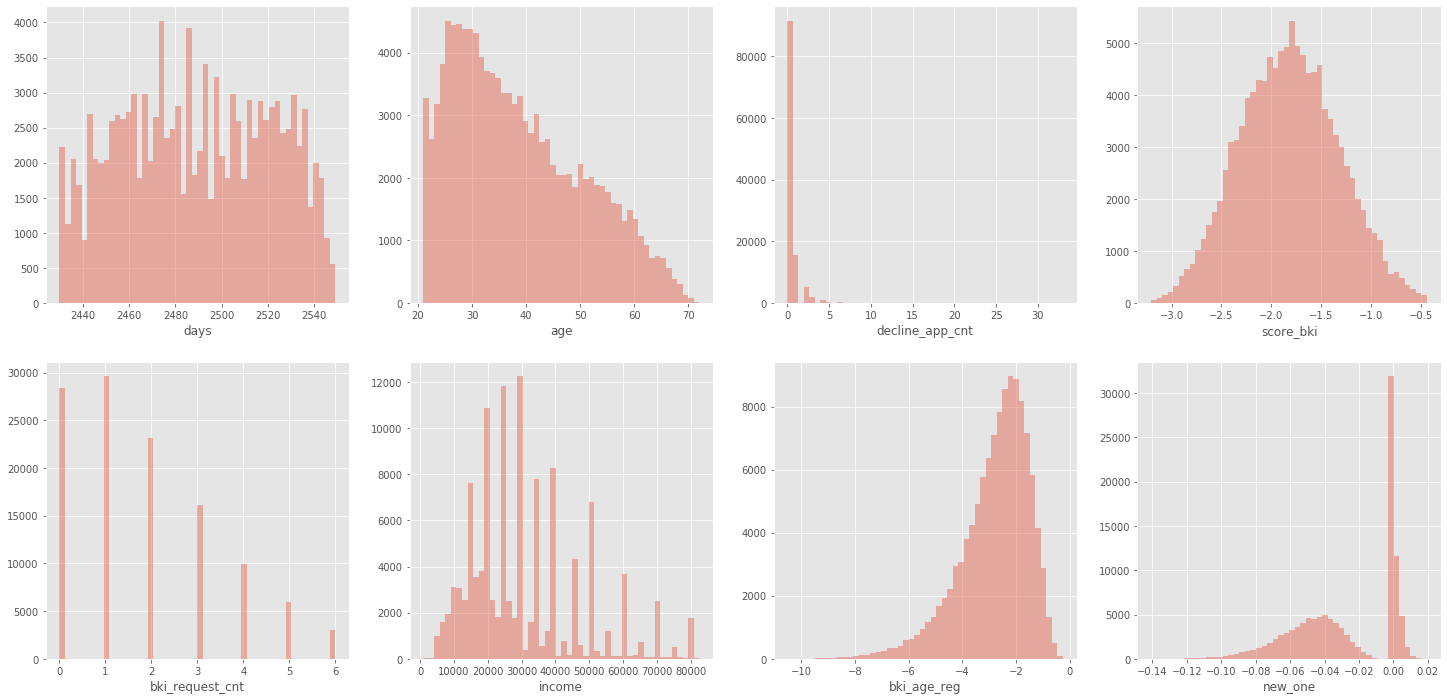

In [27]:
fig, axes = plt.subplots(2, 4, figsize=(25,12))
for col, i in zip(num_cols, range(8)):
    sns.distplot(train[col], kde=False, ax=axes.flat[i])

Прологарифмируем переменные, распределение которых смещено

In [28]:
num_cols

['days',
 'age',
 'decline_app_cnt',
 'score_bki',
 'bki_request_cnt',
 'income',
 'bki_age_reg',
 'new_one']

In [29]:
num_cols_log = ['days',
 'age',
 'decline_app_cnt',
 'bki_request_cnt',
 'income']

for i in num_cols_log:
    train[i] = np.log(train[i] + 1)

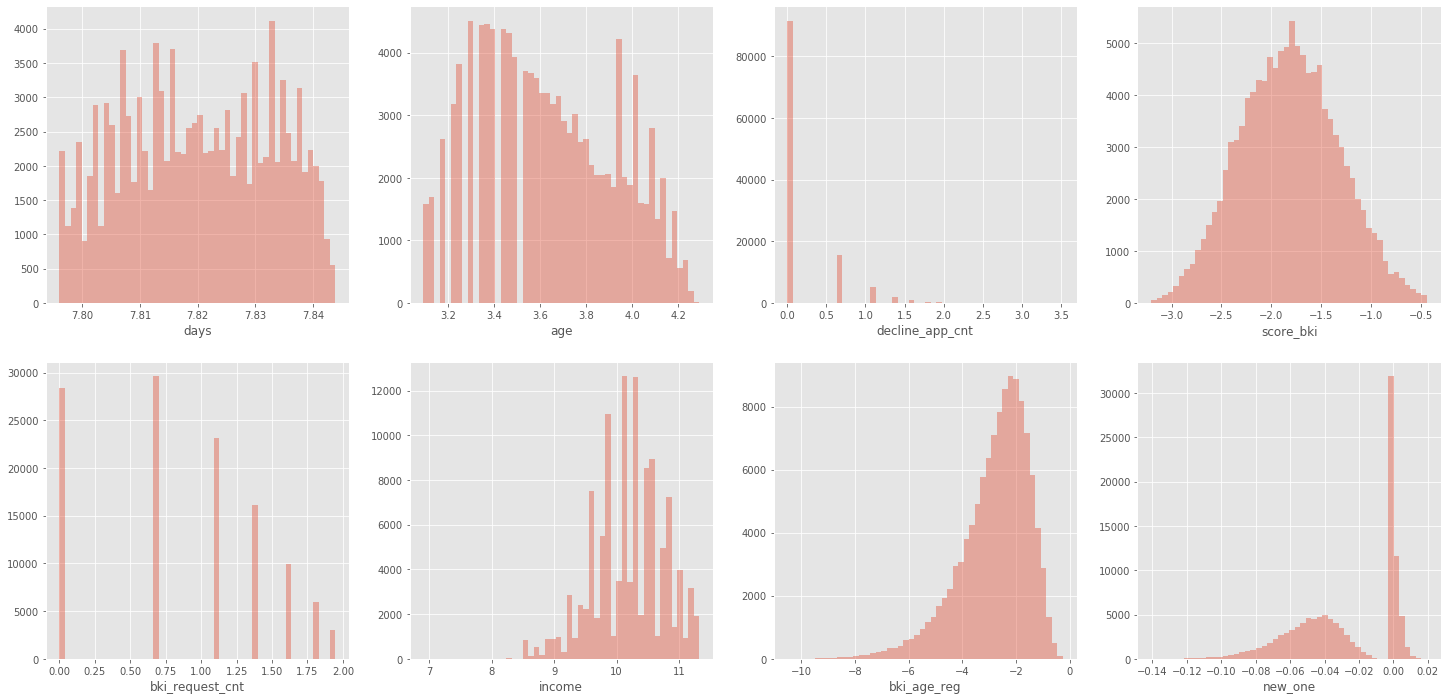

In [30]:
fig, axes = plt.subplots(2, 4, figsize=(25,12))
for col, i in zip(num_cols, range(8)):
    sns.distplot(train[col], kde=False, ax=axes.flat[i])

In [31]:
for i in num_cols_log:
    test[i] = np.log(test[i] + 1)

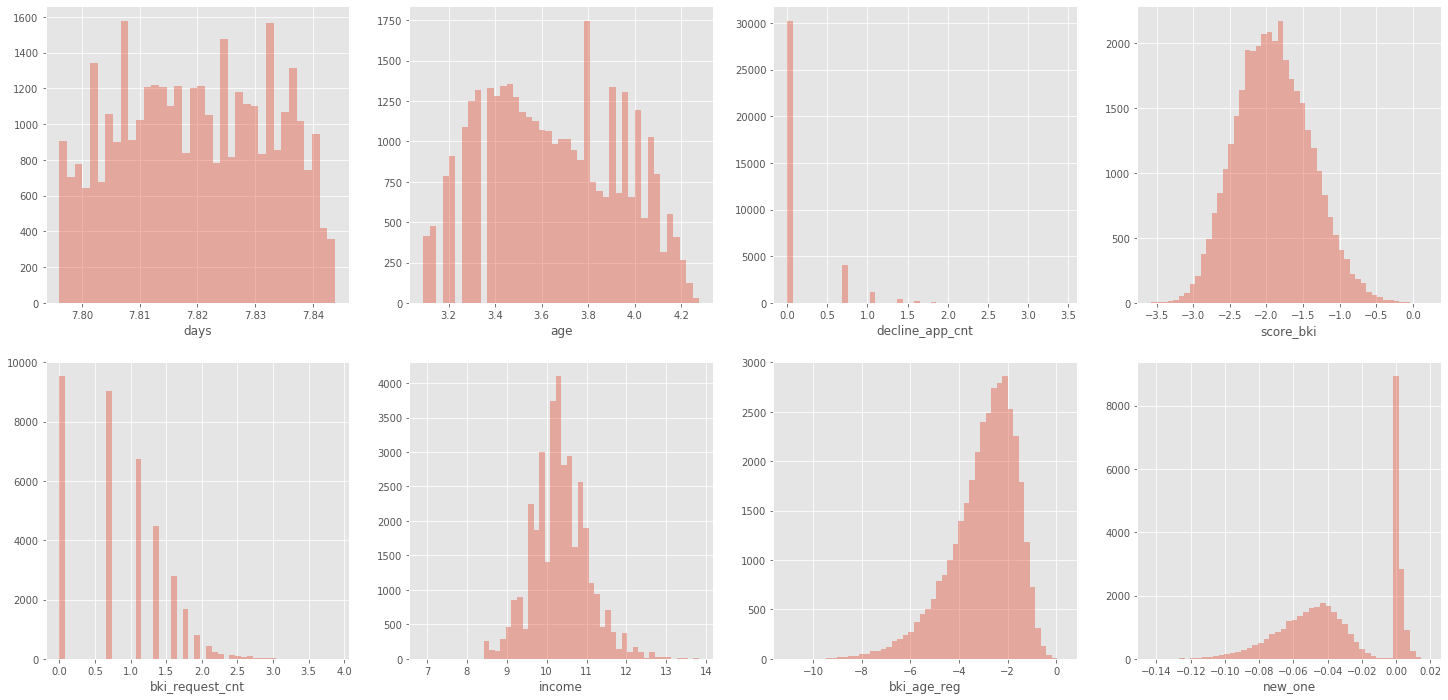

In [32]:
fig, axes = plt.subplots(2, 4, figsize=(25,12))
for col, i in zip(num_cols, range(8)):
    sns.distplot(test[col], kde=False, ax=axes.flat[i])

In [33]:
corr = train[num_cols].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,days,age,decline_app_cnt,score_bki,bki_request_cnt,income,bki_age_reg,new_one
days,1.000,-0.021,0.020,0.058,-0.008,-0.007,0.027,0.019
age,-0.021,1.000,-0.153,-0.111,0.046,-0.159,0.596,0.146
decline_app_cnt,0.020,-0.153,1.000,0.213,0.077,0.007,0.051,0.079
score_bki,0.058,-0.111,0.213,1.000,0.106,0.000,0.509,0.282
bki_request_cnt,-0.008,0.046,0.077,0.106,1.000,0.055,0.095,0.053
income,-0.007,-0.159,0.007,0.000,0.055,1.000,-0.212,-0.096
bki_age_reg,0.027,0.596,0.051,0.509,0.095,-0.212,1.000,0.305
new_one,0.019,0.146,0.079,0.282,0.053,-0.096,0.305,1.000


Высокой корреляции между признаками не наблюдается. Мультиколлинеарность появляется при коэффициенте корреляции больше 0.7

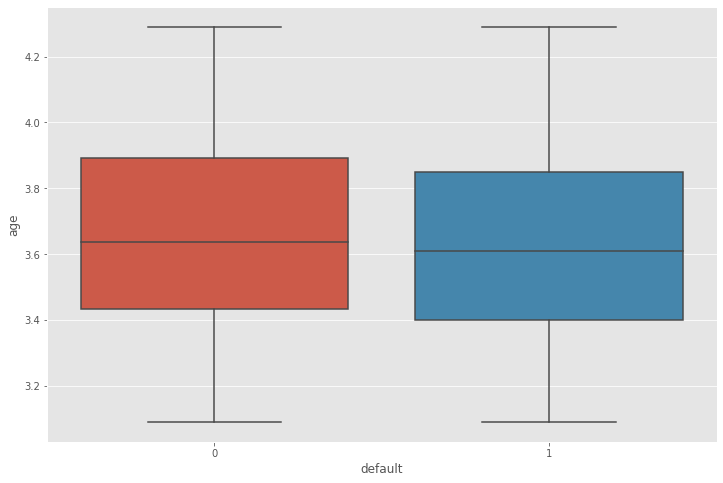

In [34]:
sns.boxplot(x=train.default, y=train.age)

Недефолтные клиенты в среднем старше дефолтных.

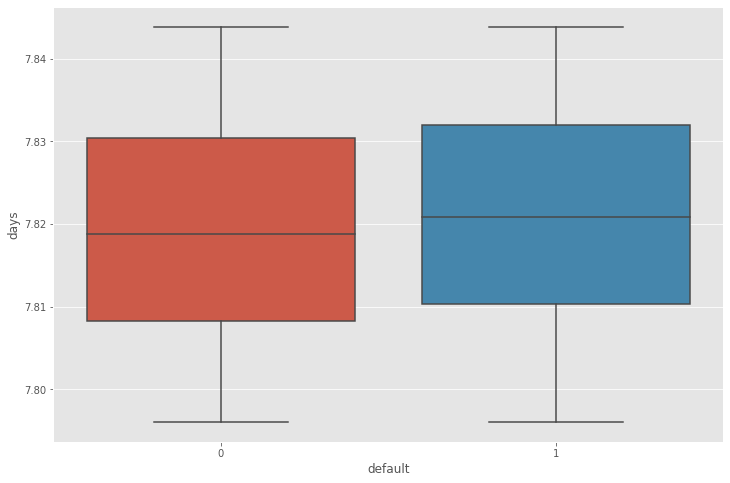

In [35]:
sns.boxplot(x=train.default, y=train.days)

Со временем банк научился чаще выдавать кредиты, что очевидно повысило его прибыльность.

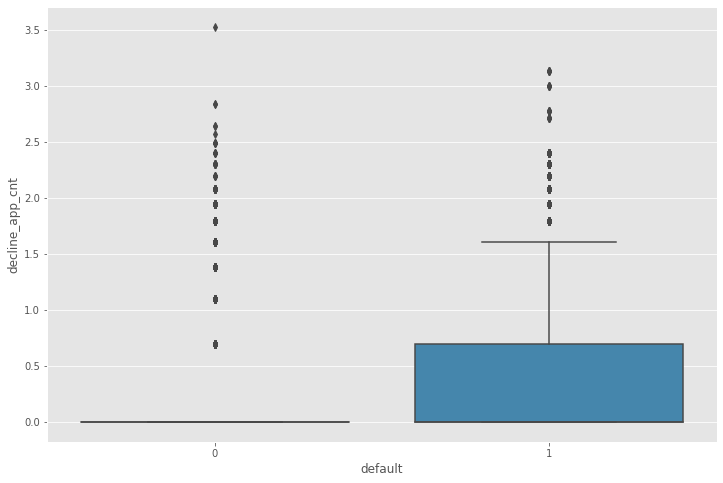

In [36]:
sns.boxplot(x=train.default, y=train.decline_app_cnt)

У дефолтных клиентов количество отклоненных заявок выше, чем у недефолтных

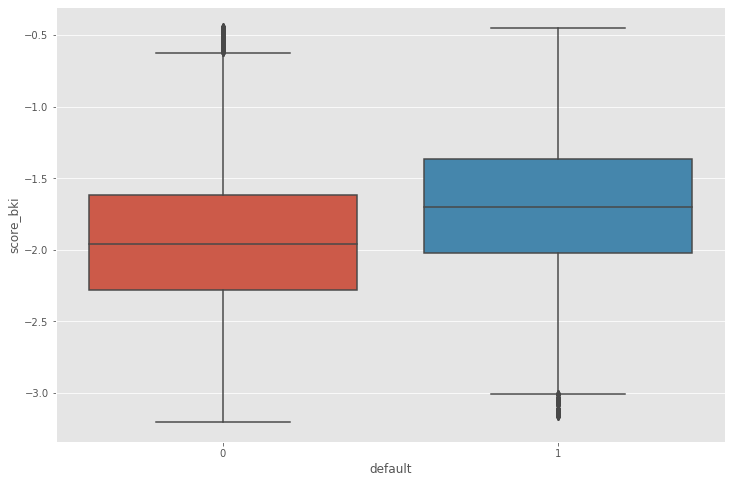

In [37]:
sns.boxplot(x=train.default, y=train.score_bki)

Средний скоринговый балл по данным из БКИ для тех, кому отказали - выше, чем для тех кому не отказали. Методика расчета этого показателя неизвестна, возможно предположить, что чем ниже балл, тем надежнее заемщик. Если иначе, то есть над чем поработать в модели.

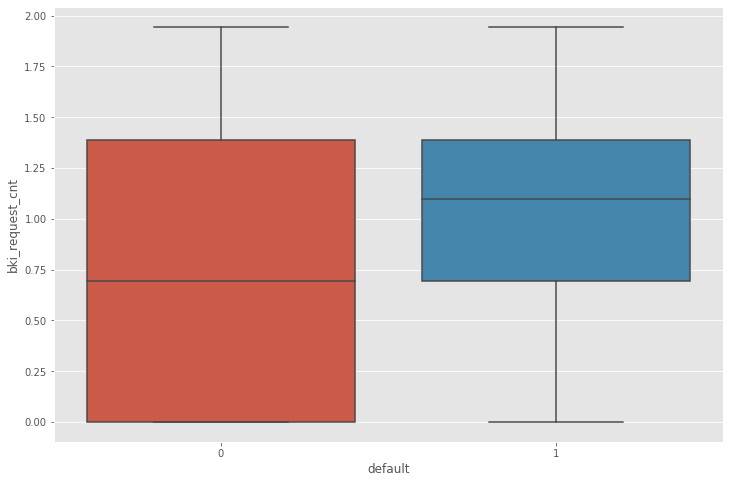

In [38]:
sns.boxplot(x=train.default, y=train.bki_request_cnt)

Средний показатель числа запросов в БКИ у дефолтных клиентов выше. 

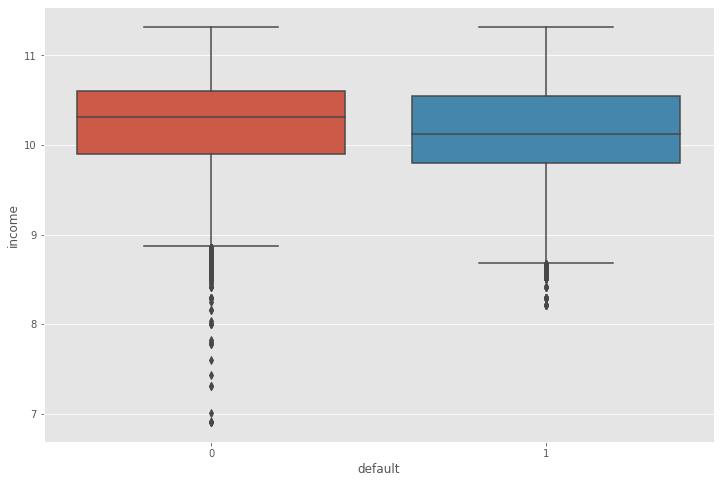

In [39]:
sns.boxplot(x=train.default, y=train.income)

Кредиты чаще выдают тем, у кого уровень дохода выше. ЧТо вполне логично.

### Преобразование бинарных и категориальных переменных
Преобразуем бинарные переменные при помощи класса LabelEncoder

In [40]:
label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    test[column] = label_encoder.fit_transform(test[column])

    
# убедимся в преобразовании    
display(train.head())
display(test.head())

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,days,bki_age_reg,new_one
0,25905,2014-02-01,SCH,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,50,1,2,9.798183,4,1,0,0,7.831617,-1.619962,1.101893e-06
1,63161,2014-03-12,SCH,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,50,2,3,9.852247,4,1,0,0,7.816014,-1.298539,4.549254e-07
2,25887,2014-02-01,SCH,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,80,1,2,10.308986,1,4,1,0,7.831617,-4.506055,-5.632569e-02
3,16222,2014-01-23,SCH,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,50,2,3,9.210440,1,3,0,0,7.835184,-1.941011,-3.882021e-02
4,101655,2014-04-18,GRD,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,60,2,3,10.308986,1,4,1,0,7.800982,-1.555903,-2.593172e-02


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,days,bki_age_reg,new_one
0,74835,2014-03-22,GRD,1,3.401197,1,1,0.000000,0,-2.271884,1.386294,50,1,2,10.819798,1,4,0,7.811973,-3.917041,-0.078341
1,17527,2014-01-24,SCH,0,3.688879,0,0,1.791759,0,-1.504999,1.098612,50,1,2,8.517393,4,3,0,7.834788,-1.929486,0.000002
2,75683,2014-03-23,UGR,1,3.931826,1,1,0.000000,0,-1.691339,0.693147,50,1,2,10.308986,1,3,1,7.811568,-1.691339,-0.033827
3,26883,2014-02-03,SCH,1,4.043051,0,0,0.000000,0,-2.374182,0.693147,40,1,2,9.741027,1,3,0,7.830823,-1.695845,-0.042396
4,28862,2014-02-04,GRD,0,3.663562,0,0,0.000000,0,-2.487502,0.000000,80,2,3,11.695255,1,3,0,7.830426,-5.236847,-0.065461


Преобразуем категориальные переменные при помощи OneHotEncoder

In [41]:
x_cat = OneHotEncoder(sparse = False).fit_transform(train[cat_cols].values)
y_cat = OneHotEncoder(sparse = False).fit_transform(test[cat_cols].values)

print(x_cat.shape)
print(y_cat.shape)

(116236, 26)
(36349, 26)


Добавляемновые новые и dummy переменные

In [42]:
train = pd.get_dummies(train, columns=['education'])

In [43]:
train = pd.get_dummies(train, columns=['region_rating'])

In [44]:
train.head()

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,home_address,work_address,income,sna,first_time,foreign_passport,default,days,bki_age_reg,new_one,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80
0,25905,2014-02-01,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,1,2,9.798183,4,1,0,0,7.831617,-1.619962,1.101893e-06,0,0,0,1,0,0,0,0,1,0,0,0
1,63161,2014-03-12,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,2,3,9.852247,4,1,0,0,7.816014,-1.298539,4.549254e-07,0,0,0,1,0,0,0,0,1,0,0,0
2,25887,2014-02-01,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,1,2,10.308986,1,4,1,0,7.831617,-4.506055,-5.632569e-02,0,0,0,1,0,0,0,0,0,0,0,1
3,16222,2014-01-23,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,2,3,9.210440,1,3,0,0,7.835184,-1.941011,-3.882021e-02,0,0,0,1,0,0,0,0,1,0,0,0
4,101655,2014-04-18,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,2,3,10.308986,1,4,1,0,7.800982,-1.555903,-2.593172e-02,0,1,0,0,0,0,0,0,0,1,0,0


In [45]:
test = pd.get_dummies(test, columns=['education'])

In [46]:
test = pd.get_dummies(test, columns=['region_rating'])
test.head()

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,home_address,work_address,income,sna,first_time,foreign_passport,days,bki_age_reg,new_one,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80
0,74835,2014-03-22,1,3.401197,1,1,0.000000,0,-2.271884,1.386294,1,2,10.819798,1,4,0,7.811973,-3.917041,-0.078341,0,1,0,0,0,0,0,0,1,0,0,0
1,17527,2014-01-24,0,3.688879,0,0,1.791759,0,-1.504999,1.098612,1,2,8.517393,4,3,0,7.834788,-1.929486,0.000002,0,0,0,1,0,0,0,0,1,0,0,0
2,75683,2014-03-23,1,3.931826,1,1,0.000000,0,-1.691339,0.693147,1,2,10.308986,1,3,1,7.811568,-1.691339,-0.033827,0,0,0,0,1,0,0,0,1,0,0,0
3,26883,2014-02-03,1,4.043051,0,0,0.000000,0,-2.374182,0.693147,1,2,9.741027,1,3,0,7.830823,-1.695845,-0.042396,0,0,0,1,0,0,0,1,0,0,0,0
4,28862,2014-02-04,0,3.663562,0,0,0.000000,0,-2.487502,0.000000,2,3,11.695255,1,3,0,7.830426,-5.236847,-0.065461,0,1,0,0,0,0,0,0,0,0,0,1


In [47]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116236 entries, 0 to 130030
Data columns (total 32 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         116236 non-null  int64         
 1   app_date          116236 non-null  datetime64[ns]
 2   sex               116236 non-null  int32         
 3   age               116236 non-null  float64       
 4   car               116236 non-null  int32         
 5   car_type          116236 non-null  int32         
 6   decline_app_cnt   116236 non-null  float64       
 7   good_work         116236 non-null  int64         
 8   score_bki         116236 non-null  float64       
 9   bki_request_cnt   116236 non-null  float64       
 10  home_address      116236 non-null  int64         
 11  work_address      116236 non-null  int64         
 12  income            116236 non-null  float64       
 13  sna               116236 non-null  int64         
 14  firs

### Значимость непрерывных переменных¶

Text(0.5, 0, 'F-value')

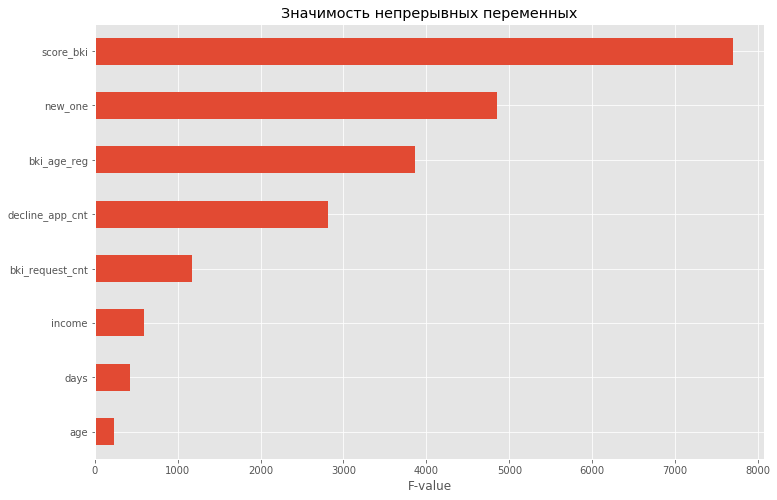

In [48]:
imp_num = Series(f_classif(train[num_cols], train['default'])[0],
                 index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')
plt.title('Значимость непрерывных переменных')
plt.xlabel('F-value')

### Значимость бинарных и категориальных переменных

Text(0.5, 1.0, 'Значимость бинарных переменных')

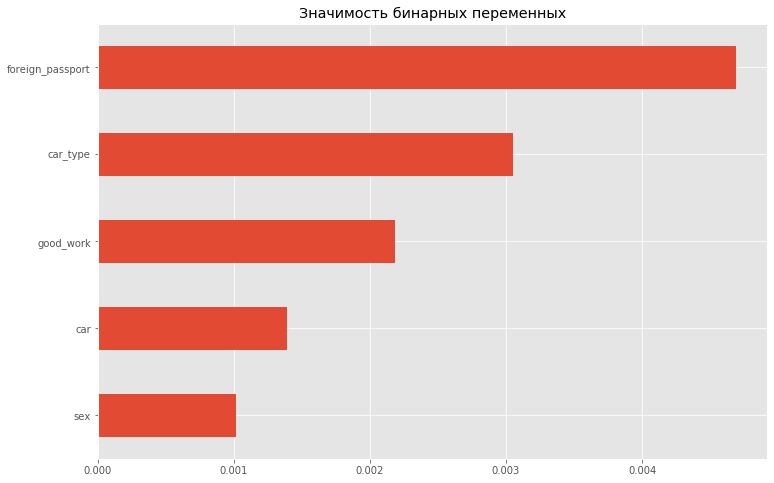

In [49]:
# Значимость бинарных признаков

imp_bin = Series(mutual_info_classif(train[bin_cols],
                                     train['default'],
                                     discrete_features=True),
                 index=bin_cols)
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh')
plt.title('Значимость бинарных переменных')

Text(0.5, 1.0, 'Significance of cat variables')

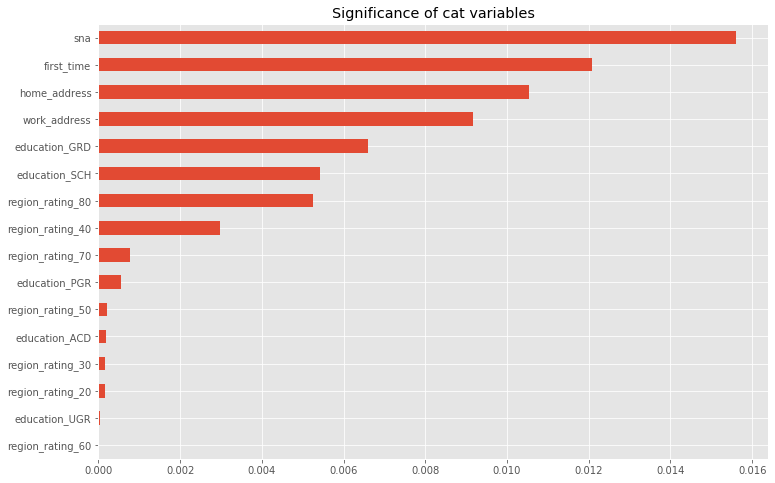

In [50]:
# Значимость категориальных признаков
new_cat_cols = [
    'home_address', 'work_address', 'sna', 'first_time', 'education_ACD',
    'education_GRD', 'education_PGR', 'education_SCH', 'education_UGR',
    'region_rating_20', 'region_rating_30', 'region_rating_40',
    'region_rating_50', 'region_rating_60', 'region_rating_70',
    'region_rating_80'
]

imp_cat = pd.Series(mutual_info_classif(train[new_cat_cols],
                                        train['default'],
                                        discrete_features=True),
                    index=train[new_cat_cols].columns)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')
plt.title('Significance of cat variables')

### Подготовка данных к машинному обучению

In [51]:
poly = PolynomialFeatures(2)

x_p = poly.fit_transform(train[num_cols].values)
y_p = poly.fit_transform(test[num_cols].values)

In [52]:
# Стандартизация числовых переменных

X_num = StandardScaler().fit_transform(x_p)
X_num.shape

(116236, 45)

In [53]:
Y_num = StandardScaler().fit_transform(y_p)
Y_num.shape

(36349, 45)

In [54]:
print(X_num)
print(Y_num)

[[ 0.          0.9049197   1.73287895 ... -0.72073328 -0.6788491
  -0.74607992]
 [ 0.         -0.31392005  1.56421113 ... -0.8187293  -0.6788401
  -0.74607992]
 [ 0.          0.9049197  -1.32670205 ...  1.12623889  1.23544522
   0.70012327]
 ...
 [ 0.         -0.471566    0.41252928 ... -0.20176001 -0.67888553
  -0.74607991]
 [ 0.          0.40718139  1.06951087 ... -0.93758274 -0.54094467
  -0.46828249]
 [ 0.          1.76840232 -0.83200179 ... -0.31528716 -0.72889406
  -0.74299326]]
[[ 0.         -0.59485181 -0.88333898 ...  0.41888969  1.30814837
   1.7642702 ]
 [ 0.          1.18058354  0.12606863 ... -0.67328704 -0.76742048
  -0.84103604]
 [ 0.         -0.62636421  0.97850869 ... -0.75433249 -0.38042248
  -0.35529597]
 ...
 [ 0.         -0.84730904 -0.65688874 ... -0.80680655 -0.76740025
  -0.84103604]
 [ 0.          1.70235156 -1.12541848 ...  0.25043697  0.37829145
   0.05778281]
 [ 0.         -0.43748093  0.0372345  ... -0.65337813 -0.76742478
  -0.84103604]]


Объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство, разделив при этом признаки и целевую переменную.

In [55]:
X = np.hstack([X_num, train[bin_cols].values, x_cat])
Y = train['default'].values

id_test = test['client_id']
test = np.hstack([Y_num, test[bin_cols].values, y_cat])

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.20,
                                                    random_state=RANDOM_SEED,
                                                    shuffle=True)

### Подбор гиперпараметров (регуляризация)

In [57]:
# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

penalty = ['l1', 'l2']
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print('Лучший penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучший penalty: l2
Лучшее C: 10000.0


In [58]:
# Обучим модель

model = LogisticRegression(penalty='l2', C=10000.0, max_iter=800)
model.fit(X_train, y_train)

LogisticRegression(C=10000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=800,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

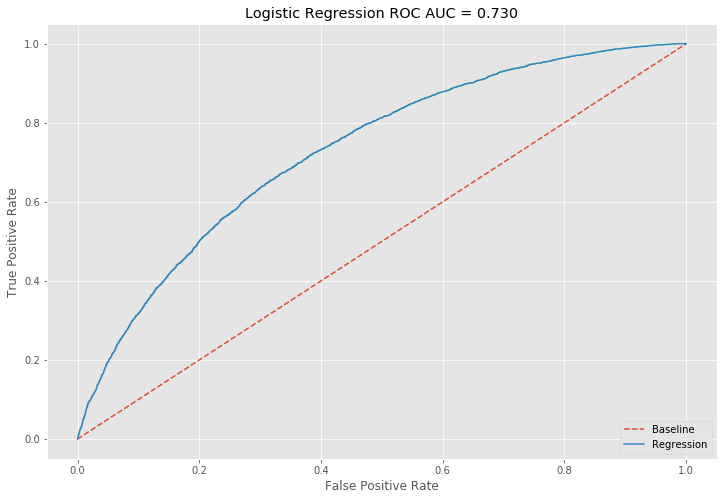

In [59]:
probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [60]:
def print_logisitc_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'acc = {acc:.2f} F1-score = {f1:.2f}')

In [61]:
Y_predicted = model.predict(X_test)
print_logisitc_metrics(y_test, Y_predicted)

acc = 0.67 F1-score = 0.67


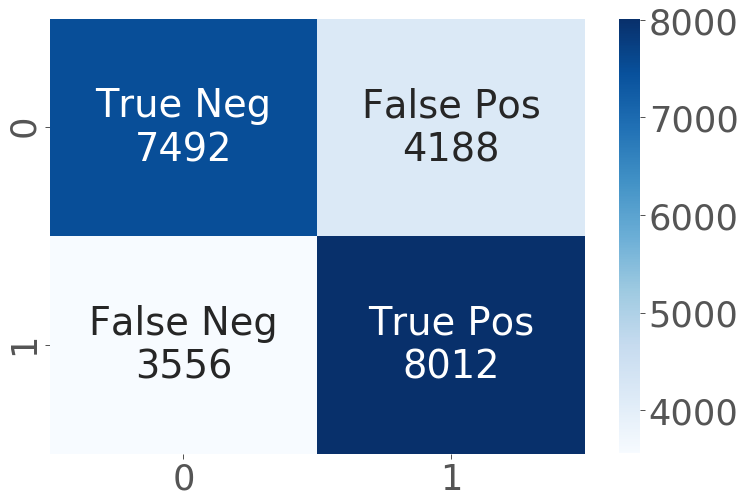

In [62]:
cm = confusion_matrix(y_test, Y_predicted)
sns.set_context(context= 'paper', font_scale=4, rc=None)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

In [63]:
model = LogisticRegression(penalty='l2', C=10000, max_iter=800)
model.fit(X, Y)
probs = model.predict_proba(test)
probs = probs[:, 1]

In [64]:
my_submission = pd.DataFrame({'client_id': id_test, 
                            'default': probs})
my_submission.to_csv('submission.csv', index=False)

my_submission

,client_id,default
0,74835,0.225089
1,17527,0.743100
2,75683,0.384378
3,26883,0.410176
4,28862,0.112101
...,...,...
36344,83775,0.792336
36345,106254,0.102944
36346,81852,0.801267
36347,1971,0.691510
